<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/tanques_Pinn_classica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
import keras
print('Versão do TensorFlow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Lambda, Dropout
from keras.regularizers import l2


import pandas as pd

# configurações especiais
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
epsilon = tf.constant(1e-8, dtype=DTYPE)
tf.random.set_seed(1234)
np.random.seed(1234)
plt.rcParams['axes.grid'] = True

if tf.config.experimental.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Versão do TensorFlow: 2.15.0
Using CPU


In [3]:
#%% Sistema físico

# Carregando os dados experimentais
dados = pd.read_csv("dataBenchmark.csv", index_col=False)
U_star = dados[['uEst','uVal']].to_numpy()
Y2_star = dados[['yEst','yVal']].to_numpy()

# Tempode amostragem
T = 4.0

# Volume máximo
x1_MAX = tf.constant(15.0, dtype=DTYPE)
x2_MAX = tf.constant(10.0, dtype=DTYPE)
ZERO = tf.constant(0.0, dtype=DTYPE)

# Entradas = [T, u, x10, x20]
lb = tf.constant([0, np.min(U_star), np.min(Y2_star), np.min(Y2_star)], dtype=DTYPE) # limites inferiores
ub = tf.constant([T, np.max(U_star), np.max(Y2_star), np.max(Y2_star)], dtype=DTYPE) # limites superiores

# Parâmetros extras (refined_params)
k1, k2, k3, k4, k5, x1_init, x2_init = [0.12292085, 0.00688274, 0.01786924, 0.2283084 , 0.04471271, 2.68308331, 5.6011849 ]
x_init0 = tf.constant([x1_init, x2_init])

In [4]:
def physics_model(x, u):

  # estados
  x1, x2 = x[:,0:1], x[:,1:2]

  # Parâmetros extras (refined_params)
  k1, k2, k3, k4, k5  = [0.12292085, 0.00688274, 0.01786924, 0.2283084 , 0.04471271 ]

  # Modelo diferencial
  f1 = -k1 * tf.sqrt(x1) + k4 * u
  #f2 =  k2 * tf.sqrt(x1) - k3 * tf.sqrt(x2) + k5 * tf.nn.relu(x1 - x1_MAX)
  f2 =  k2 * tf.sqrt(x1) - k3 * tf.sqrt(x2) + k5 * tf.nn.softplus(x1 - x1_MAX)

  return tf.concat([f1, f2], 1)

In [5]:
#%% Dados experimentais (treino)
N_train = len(Y2_star)
t_train = tf.linspace(0.0,(N_train-1)*T,N_train)[:,tf.newaxis]
u_train = tf.constant(U_star[:,0:1], dtype=DTYPE)
y_train = tf.constant(Y2_star[:,0:1], dtype=DTYPE)
v_train = tf.concat([t_train, u_train, tf.ones((N_train,2))*x_init0], axis=1)

In [6]:
#%% Dado de treinamento da condição inicial
N_t = 100
t0_train = tf.zeros((N_t,1))
u0_train = tf.random.uniform((N_t,1), minval=lb[1], maxval=ub[1])
x0_train = tf.random.uniform((N_t,2), minval=lb[2:], maxval=ub[2:])
v_0 = tf.concat([t0_train, u0_train, x0_train], axis=1)


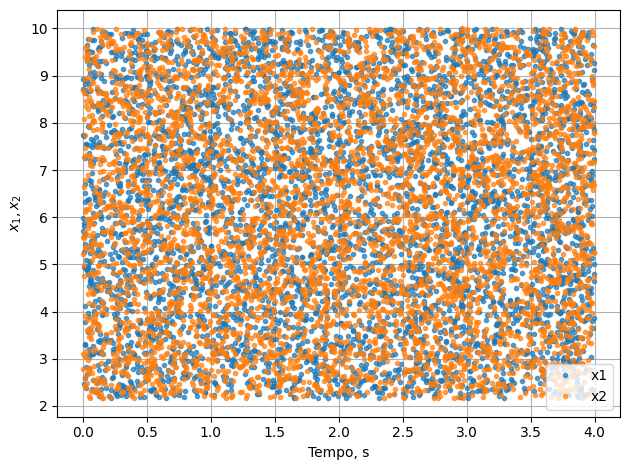

In [7]:
#%% Pontos de colocação
N_f = 5000

# criando amostras randômicas
v_col = tf.random.uniform((N_f,4), minval=lb, maxval=ub)

plt.figure()
plt.plot(v_col[:,0], v_col[:,2:], '.', alpha=0.7)
plt.legend(['x1', 'x2']);
plt.xlabel('Tempo, s');
plt.ylabel(r'$x_1, x_2$');
plt.tight_layout()

In [8]:
N_layers = 4
N_neurons = 50

# Função para inicializar o modelo PINN
def init_model_API(num_input=4, num_hidden_layers=N_layers, num_neurons_per_layer=N_neurons):
    # Entradas
    layer0 = layer = Input(shape=(num_input,), name='Entrada')

    # Aplicando a camada de escala, se existir
    scaling_layer = Lambda(
    lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0,
    name='Normalizar',
    output_shape=(4,)  # Especificando a forma da saída
)
    layer = scaling_layer(layer)

    for i in range(num_hidden_layers):
        layer = Dense(num_neurons_per_layer, activation='tanh',
                      kernel_initializer='glorot_normal',
                      use_bias=True, bias_initializer='zeros',
                      name='Oculta'+str(i+1))(layer)

    # Camada de saída
    layer = Dense(2, activation='softmax', name='Saida')(layer)

    # Criando o modelo final
    model = Model(inputs=layer0, outputs=layer)
    return model

pinn = init_model_API()
pinn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 4)]               0         
                                                                 
 Normalizar (Lambda)         (None, 4)                 0         
                                                                 
 Oculta1 (Dense)             (None, 50)                250       
                                                                 
 Oculta2 (Dense)             (None, 50)                2550      
                                                                 
 Oculta3 (Dense)             (None, 50)                2550      
                                                                 
 Oculta4 (Dense)             (None, 50)                2550      
                                                                 
 Saida (Dense)               (None, 2)                 102   

In [9]:
@tf.function
def system_RK(net, t):

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t)
      input = tf.concat([t, v_col[:,1:]], axis=1)
      output = net(input)

      y1_hat = output[:,0:1]
      y2_hat = output[:,1:2]

      y1_t = tape.gradient(y1_hat, t)
      y2_t = tape.gradient(y2_hat, t)
      del tape

    # Resíduos
    if y1_t is None or y2_t is None:
      raise ValueError("Gradientes são None")

    # aprovximação do sistema físico
    u = v_col[:,1:2]
    dy = tf.concat([y1_t, y2_t], 1)
    F = dy - physics_model(output, u)
    MSE_f = tf.reduce_mean(F**2)

    # Condição inicial
    output_0 = net(v_0)
    MSE_0 = tf.reduce_mean((output_0-v_0[:,2:])**2)

    # Dados experimentais
    output_train = net(v_train)
    MSE_y = tf.reduce_mean((output_train[:,1]-y_train)**2)

    return MSE_f + MSE_y

# system_RK(pinn, v_col[:,0:1])

In [ ]:
# Inicializar treinamento com Adam
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optm = tf.keras.optimizers.Adam(learning_rate=0.01)

#%% Treinamento inicial com Adam
epochs_adam = 2001
fun_hist = []
for it in range(epochs_adam):
    with tf.GradientTape() as tape:
        loss = system_RK(pinn, v_col[:,0:1])

    gradients = tape.gradient(loss, pinn.trainable_variables)
    optm.apply_gradients(zip(gradients, pinn.trainable_variables))
    fun_hist.append(loss.numpy())

    if it % 100 == 0:
        print(f'Adam - Iteration {it}, Loss: {loss.numpy()}')

Adam - Iteration 0, Loss: 28.347604751586914


In [ ]:
def update_model_weights(model, weights):
    """ Update model weights with a 1D vector of weights. """
    shapes = [w.shape for w in model.trainable_variables]
    params = []
    offset = 0
    for shape in shapes:
        size = tf.reduce_prod(shape)
        param = tf.reshape(weights[offset:offset+size], shape)
        params.append(param)
        offset += size
    for i, param in enumerate(params):
        model.trainable_variables[i].assign(param)

def parameters_to_1D_vector(parameters):
    return tf.concat([tf.reshape(param, [-1]) for param in parameters], axis=0)

def f_val_and_grad(x):
    x = tf.cast(x, tf.float32)
    update_model_weights(pinn, x)

    with tf.GradientTape() as tape:
        loss = system_RK(pinn, v_col[:,0:1])

    gradients = tape.gradient(loss, pinn.trainable_variables)
    gradients_vec = parameters_to_1D_vector(gradients)
    fun_hist.append(loss.numpy())

    return loss.numpy(), gradients_vec.numpy()

#%% Otimização com L-BFGS
initial_parameters = parameters_to_1D_vector(pinn.trainable_variables).numpy()

x, f, d = fmin_l_bfgs_b(f_val_and_grad, initial_parameters, maxiter=1000)

update_model_weights(pinn, tf.cast(x, tf.float32))

print('Final loss:', f)

In [ ]:
# Dados experimentais
output_train = pinn(v_train)
MSE_y = tf.reduce_mean((output_train[:,1]-y_train)**2)
print(MSE_y)

plt.plot(c)
plt.plot(y_train,'--k');
plt.legend(['x1 Predito', 'x2 Predito', 'x2 Real'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [ ]:
output_train

# apenas baseado em dados

In [ ]:
# Função para inicializar o modelo PINN
def init_model_API(num_input=1, num_hidden_layers=N_layers, num_neurons_per_layer=N_neurons):
    # Entradas
    layer0 = layer = Input(shape=(num_input,), name='Entrada')

    # Aplicando a camada de escala, se existir
    scaling_layer = Lambda(
    lambda x: 2.0 * (x - lb[1]) / (ub[1] - lb[1]) - 1.0,
    name='Normalizar',
    output_shape=(4,)  # Especificando a forma da saída
)
    layer = scaling_layer(layer)

    for i in range(num_hidden_layers):
        layer = Dense(num_neurons_per_layer, activation='tanh',
                      kernel_initializer='glorot_normal',
                      use_bias=True, bias_initializer='zeros',
                      name='Oculta'+str(i+1))(layer)

    # Camada de saída
    layer = Dense(1, activation='softmax', name='Saida')(layer)

    # Criando o modelo final
    model = Model(inputs=layer0, outputs=layer)
    return model

model = init_model_API()
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
model.fit(u_train, y_train, epochs=1000, verbose=0)

In [ ]:
lb,ub

In [ ]:
def build_model():

  layer0 = Input(shape=(1,), name='Entrada')
  layer = Lambda(lambda x: 2.0 * (x - lb[1]) / (ub[1] - lb[1]) - 1.0)(layer0)
  layer = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(layer)
  layer = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(layer)
  layer = Dense(1, activation='tanh', name='Saida')(layer)

  model = Model(inputs=layer0, outputs=layer)

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

In [ ]:
model.fit(u_train.numpy(), y_train.numpy(), epochs=100, verbose=0)

In [ ]:
yhat = model.predict(u_train)
plt.plot(u_train)
plt.plot(y_train)
plt.plot(yhat,  '--k')
plt.legend(['u', 'y', 'yhat'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
yhat2 = model.predict(U_star[:,1][:,tf.newaxis])

In [ ]:
plt.plot(y_train)
plt.plot(yhat2,  '--k')
plt.legend(['u', 'y', 'yhat'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supondo que X_train e y_train sejam seus dados de treinamento

# Normalização dos dados de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(u_train)

# Criação do modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(u_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Sem ativação para regressão
])

# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Treinamento do modelo
history = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=32, validation_split=0.0, verbose=0)

In [ ]:
# Verificação da função de perda durante o treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Teste do modelo (normalização dos dados de teste)
X_test_scaled = scaler.transform(u_train)
predictions = model.predict(X_test_scaled)

In [ ]:
plt.plot(y_train)
plt.plot(predictions,  '--k')
plt.legend(['y', 'yhat'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
u_train_scaled = scaler.fit_transform(u_train)

u_train_smoothed = pd.Series(U_star[:,0]).rolling(window=50).mean()

# Aplicando a média móvel
window_size = int(60/4)  # Ajuste conforme necessário
smoothed_u_train = pd.Series(U_star[:,0]).rolling(window=window_size).mean()
smoothed_u_train = smoothed_u_train.fillna(method='bfill')  # Preenchendo valores NaN


plt.plot(U_star[:,0]);
#plt.plot(u_train_scaled);
#plt.plot(u_train_smoothed[48:].to_numpy());
plt.plot(smoothed_u_train);

In [ ]:
model.fit(smoothed_u_train, y_train, epochs=100, verbose=1)

In [ ]:
u_train_fft = np.fft.fft(u_train)
frequencies = np.fft.fftfreq(len(u_train))

# Plotando o espectro de frequência
plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(u_train_fft))
plt.title("Espectro de Frequência do Sinal")
plt.xlabel("Frequência")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt

# Função para aplicar um filtro passa-baixa com comprimento de padding ajustado
def butter_lowpass_filter(data, cutoff, fs, order=5, padlen=250):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, padlen=padlen)
    return y

# Aplicando o filtro passa-baixa com comprimento de padding ajustado
cutoff_frequency = 0.01  # Ajuste conforme necessário
fs = 1/4  # Frequência de amostragem, ajuste conforme necessário
filtered_u_train = butter_lowpass_filter(U_star[:,0], cutoff_frequency, fs)

# Visualização do sinal filtrado
plt.figure(figsize=(12, 6))
plt.plot(u_train, label='Original')
plt.plot(filtered_u_train, '--k', label='Filtrado')
plt.title("Sinal Original e Filtrado")
plt.xlabel("Amostra")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculando a potência das principais frequências
def extract_frequency_features(signal, top_n=5):
    fft_values = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal))
    magnitude = np.abs(fft_values)

    # Ordenando as frequências pela magnitude
    sorted_indices = np.argsort(magnitude)[::-1]
    top_frequencies = frequencies[sorted_indices[:top_n]]
    top_magnitudes = magnitude[sorted_indices[:top_n]]

    return top_frequencies, top_magnitudes

# Extraindo características de frequência
top_frequencies, top_magnitudes = extract_frequency_features(U_star[:,0])
print(top_frequencies, top_magnitudes)

# Usando as magnitudes das principais frequências como features adicionais
features = np.column_stack((U_star[:,0], top_magnitudes))
